- Refer to the below for Details

- https://haythamfayek.com/2016/04/21/speech-processing-for-machine-learning.html

In [32]:
import numpy as np
import scipy.io.wavfile
from scipy.fftpack import dct
import matplotlib.pyplot as plt
from matplotlib import cm

In [ ]:
sample_rate, signal = scipy.io.wavfile.read('test1-01.wav')  # File assumed to be in the same directory
signal = signal[0:int(3.5 * sample_rate)]  # Keep the first 3.5 seconds

## Pre-Emphasis

In [4]:
pre_emphasis = 0.9
emphasized_signal = numpy.append(signal[0], signal[1:] - pre_emphasis * signal[:-1])

## Framing

In [6]:
frame_size = 0.025
frame_stride = 0.01

In [7]:
frame_length, frame_step = frame_size * sample_rate, frame_stride * sample_rate  # Convert from seconds to samples
signal_length = len(emphasized_signal)
frame_length = int(round(frame_length))
frame_step = int(round(frame_step))
num_frames = int(numpy.ceil(float(numpy.abs(signal_length - frame_length)) / frame_step))  # Make sure that we have at least 1 frame

pad_signal_length = num_frames * frame_step + frame_length
z = numpy.zeros((pad_signal_length - signal_length))
pad_signal = numpy.append(emphasized_signal, z) # Pad Signal to make sure that all frames have equal number of samples without truncating any samples from the original signal

indices = numpy.tile(numpy.arange(0, frame_length), (num_frames, 1)) + numpy.tile(numpy.arange(0, num_frames * frame_step, frame_step), (frame_length, 1)).T
frames = pad_signal[indices.astype(numpy.int32, copy=False)]

## Window

In [8]:
frames *= numpy.hamming(frame_length)
# frames *= 0.54 - 0.46 * numpy.cos((2 * numpy.pi * n) / (frame_length - 1))  # Explicit Implementation **

## Fourier-Transform and Power Spectrum

In [13]:
NFFT = 512;

In [14]:
mag_frames = numpy.absolute(numpy.fft.rfft(frames, NFFT))  # Magnitude of the FFT
pow_frames = ((1.0 / NFFT) * ((mag_frames) ** 2))  # Power Spectrum

## Filter Banks

In [16]:
nfilt = 40

In [17]:
low_freq_mel = 0
high_freq_mel = (2595 * numpy.log10(1 + (sample_rate / 2) / 700))  # Convert Hz to Mel
mel_points = numpy.linspace(low_freq_mel, high_freq_mel, nfilt + 2)  # Equally spaced in Mel scale
hz_points = (700 * (10**(mel_points / 2595) - 1))  # Convert Mel to Hz
bin = numpy.floor((NFFT + 1) * hz_points / sample_rate)

fbank = numpy.zeros((nfilt, int(numpy.floor(NFFT / 2 + 1))))
for m in range(1, nfilt + 1):
    f_m_minus = int(bin[m - 1])   # left
    f_m = int(bin[m])             # center
    f_m_plus = int(bin[m + 1])    # right

    for k in range(f_m_minus, f_m):
        fbank[m - 1, k] = (k - bin[m - 1]) / (bin[m] - bin[m - 1])
    for k in range(f_m, f_m_plus):
        fbank[m - 1, k] = (bin[m + 1] - k) / (bin[m + 1] - bin[m])
filter_banks = numpy.dot(pow_frames, fbank.T)
filter_banks = numpy.where(filter_banks == 0, numpy.finfo(float).eps, filter_banks)  # Numerical Stability
filter_banks = 20 * numpy.log10(filter_banks)  # dB

## Mel-frequency Cepstral Coefficients (MFCCs)

In [18]:
num_ceps = 40

In [23]:
mfcc = dct(filter_banks, type=2, axis=1, norm='ortho')[:, 0 : (num_ceps + 1)] # Keep 2-13

In [24]:
mfcc.shape

(698, 40)

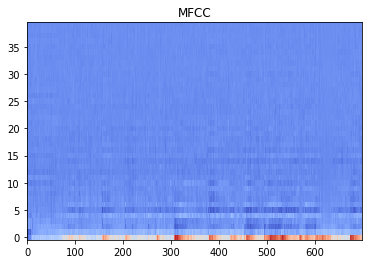

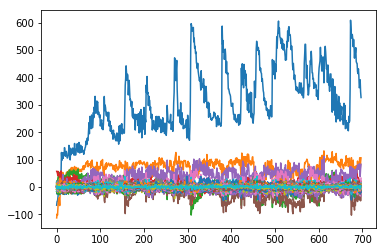

In [36]:
ig, ax = plt.subplots()
mfcc_data= np.swapaxes(mfcc, 0 ,1)
cax = ax.imshow(mfcc_data, interpolation='nearest', cmap=cm.coolwarm, origin='lower', aspect='auto')
ax.set_title('MFCC')
#Showing mfcc_data
plt.show()
#Showing mfcc_feat
plt.plot(mfcc)
plt.show()

In [37]:
mfcc_data.shape

(40, 698)